# Dimensionality Reduction

## 1. Introduction

Data is everywhere! And throughout the years, more and more real-world observations are being tracked and recorded in data sets. This often results in data sets that are very high-dimensional. Sometimes, though, you only want to keep the variables that are the most important ones. There are very advances techniques to do this, but a little bit of data exploring goes a long way!

In this lecture, we'll give an overview of four fairly ad-hoc ways to significantly reduce the amount of data you have, whitout harming the predictive power of the eventual model! The four techniques that will be discussed are:

- Deleting variables with a high amount of missingness
- Deleting highly correlated variables
- Grouping classes together for categorical variables that have many categories

## 2. The data: a first glance

The data set we'll look at was created with records of absenteeism at work from July 2007 to July 2010 at a courier company in Brazil. Imagine the purpose of the data set is to *model absenteeism* based on several factors. Let's load the data and look at some summary statistics.

In [139]:
import pandas as pd
import numpy as np
data = pd.read_csv("absence_data.csv", sep = ',', index_col = 0)
import matplotlib.pyplot as plt
data.head()

,Reason for absence,Month,Day of the week,Seasons,Transportation expense,Distance to Work,Service time,Age,Work load,Education,Son,Social drinker,Social smoker,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,NaN,33,239.554,1,2,1,0,90,172,30,4
1,0,7,3,1,118,13,NaN,50,239.554,1,1,1,0,98,178,31,0
2,23,7,4,1,179,51,NaN,38,239.554,1,0,1,0,89,170,31,2
3,7,7,5,1,279,5,14.0,39,239.554,1,2,1,1,68,168,24,4
4,23,7,5,1,289,36,NaN,33,239.554,1,2,1,0,90,172,30,2


In [140]:
data.shape

(413, 17)

The variables in the data set are:

1. reason for absence (a class variable with 28 classes, we'll discuss in more detail below)
2. Month (1-12)
3. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
4. Seasons
5. Transportation expense
6. Distance to Work (kilometers)
7. Service time
8. Age
9. Work load per day
10. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
11. Son (number of children)
12. Social drinker (yes=1; no=0)
13. Social smoker (yes=1; no=0)
14. Weight
15. Height
16. Body mass index
17. Absenteeism time in hours (target)

The data has 17 columns and 413 rows. Admittedly, this isn't a massive high-dimensional data set, but pretty good for learning purposes here. Let's have a look at the data and see how we can reduce dimensionality here!

## 3. Deleting variables with high amount of missingness

By looking at just the head of the data, which we did previously, it already became apparent that there are some missing values for the variable `value_count`.

In [141]:
data.isna().any()

Reason for absence           False
Month                        False
Day of the week              False
Seasons                      False
Transportation expense       False
Distance to Work             False
Service time                  True
Age                          False
Work load                     True
Education                    False
Son                          False
Social drinker               False
Social smoker                False
Weight                       False
Height                       False
Body mass index              False
Absenteeism time in hours    False
dtype: bool

Seems like there are missing values for work load too! Lets's have a look at the extent of the missingness.

In [142]:
service_n_missing = data['Service time'].isna().sum()
service_n_missing

260

Seems like that is quite a lot! Let's see what fraction this represents.

In [143]:
service_fraction_missing = service_n_missing / len(data)
service_fraction_missing

0.6295399515738499

As we have more than half of the instances missing, we'll delete it later. Let's repeat this for the variable `work load`

In [144]:
work_load_n_missing = data['Work load'].isna().sum()

In [145]:
work_load_fraction_missing = work_load_n_missing / len(data)
work_load_fraction_missing

0.29782082324455206

The missingness for the `work load` variable is close to 30%. Although this is definitely a lower missingness the  the one for `service`, 30% is still significant enought to remove the variable. 

Generally, for lower missingness rates, you might argue that you can use imputation rules (replacing by the mean, replacing by the modal class,...). For the purpose of this lecture, we'll delete both the "Service time" and the `Work load` variable. In practice, the final decision will depend on several factors, such as general decision rules set up front, or simply how important it is to still try and keep a certain variable in the data set.

In [146]:
data = data.drop(columns=['Service time', 'Work load'])

## 4. Deleting highly correlated variables

When you build a model, it is important to not have variables in your model that are highly correlated for several reasons. One of the reasons is that the interpretation of the parameter estimates might become distorted if you do this. Additionally, it is just not very useful to have highly correlated in your model as predictors when they are highly correlated. Let's have another glance at the remaining data.

In [147]:
data.head()

,Reason for absence,Month,Day of the week,Seasons,Transportation expense,Distance to Work,Age,Education,Son,Social drinker,Social smoker,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,33,1,2,1,0,90,172,30,4
1,0,7,3,1,118,13,50,1,1,1,0,98,178,31,0
2,23,7,4,1,179,51,38,1,0,1,0,89,170,31,2
3,7,7,5,1,279,5,39,1,2,1,1,68,168,24,4
4,23,7,5,1,289,36,33,1,2,1,0,90,172,30,2


Let's have a look at `Transportation expense` and `Distance to work`. Depending on whether the company set up the transportation expenses for commuting, these two variables might be correlated.

In [148]:
np.corrcoef(data['Transportation expense'], data['Distance to Work'])[0,1]

0.17455862905158437

This doesn't seem to be the case! How about weight and height? You would assume that taller people will generally be heavier too.

In [149]:
np.corrcoef(data['Weight'], data['Height'])[0,1]

0.3040706707220844

Well, it turns out that's not quite the case. Now, let's look at weight and body mass index. We know for a fact that the BMI is calculated using someone's weight and height.

In [150]:
np.corrcoef(data['Weight'], data['Body mass index'])[0,1]

0.9105297231349522

This is clearly highly correlated! We could go on and calculate the correlations between each variable pair, but that wouldn't be very efficient. What we can do is create a *heatmap* of the correlations across variables. This is a visual representation of the correlations. On the diagonal, you can find the correlations of variables with themselves, which is always equal to 1. We are particularly looking for off-diagonal yellow squares, denoting high correlations between two variables

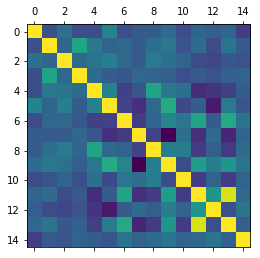

In [151]:
plt.matshow(data.corr())

it seems like BMI and weight are really the only two highly correlated variables! You can generally choose which one of the two to delete. Here, we'll go for the BMI variable!

In [153]:
data = data.drop(columns=['Body mass index'])

In [155]:
data.head()

,Reason for absence,Month,Day of the week,Seasons,Transportation expense,Distance to Work,Age,Education,Son,Social drinker,Social smoker,Weight,Height,Absenteeism time in hours
0,26,7,3,1,289,36,33,1,2,1,0,90,172,4
1,0,7,3,1,118,13,50,1,1,1,0,98,178,0
2,23,7,4,1,179,51,38,1,0,1,0,89,170,2
3,7,7,5,1,279,5,39,1,2,1,1,68,168,4
4,23,7,5,1,289,36,33,1,2,1,0,90,172,2


## 5. Grouping classes together for categorical variables that have many categories

The variable "Reason for absence" has 28 categories (and one category *unknown*, denoted by 0).

- 0) unknown
- 1) Certain infectious and parasitic diseases  
- 2) Neoplasms  
- 3) Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism  
- 4) Endocrine, nutritional and metabolic diseases  
- 5) Mental and behavioural disorders  
- 6) Diseases of the nervous system  
- 7) Diseases of the eye and adnexa  
- 8) Diseases of the ear and mastoid process  
- 9) Diseases of the circulatory system  
- 10) Diseases of the respiratory system  
- 11) Diseases of the digestive system  
- 12) Diseases of the skin and subcutaneous tissue  
- 13) Diseases of the musculoskeletal system and connective tissue  
- 14) Diseases of the genitourinary system  
- 15) Pregnancy, childbirth and the puerperium  
- 16) Certain conditions originating in the perinatal period  
- 17) Congenital malformations, deformations and chromosomal abnormalities  
- 18) Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified  
- 19) Injury, poisoning and certain other consequences of external causes  
- 20) External causes of morbidity and mortality  
- 21) Factors influencing health status and contact with health services.
- 22) patient follow-up
- 23) medical consultation
- 24) blood donation
- 25) laboratory examination
- 26) unjustified absence
- 27) physiotherapy
- 28) dental consultation


At first glance, having 29 categories (28 and some unknowns, given by 0) does not seem like a dimensionality issue per se, as it is still contained in one variable. But remember that for many problems, each one of these classes will be transformed in its own column of dummy variables. So essentially, we would end op with 29-1 additional columns here. We have a fairly small data set, so it just doesn't seem appropriate to keep all 29 categories. A popular strategy that is being used is by grouping certain variables together. Before we decide *how* we will do this, let's have a look at the data by looking at the value counts.

In [164]:
data.head()
data["Reason for absence"].value_counts().count()
data["Reason for absence"].value_counts()
# nothing for 2 & 20

23    93
28    74
13    35
27    29
0     24
22    19
26    19
19    18
11    17
25    14
10    13
18    12
1     11
14    10
7      5
12     3
8      3
6      3
9      2
24     2
15     1
16     1
17     1
5      1
4      1
3      1
21     1
Name: Reason for absence, dtype: int64

We notice that only 27 categories are found in the data: seems like categories `2` (Neoplasms) and `20` (External causes of morbidity and mortality) are not present. Additionally, quite a few categories only have 1 occurrence. When fitting models, this might lead to issues such as singularity. What we decided to do here, is keep the 5 most occurring categories ("medical consultation", "dental consultation",  "Diseases of the musculoskeletal system and connective tissue", "physiotherapy" and "unknown", and then we group all the other variables together in a new variable "other". Let's try and do this here. We'll also rename the other categories.

In [169]:
data["Reason for absence"] = data["Reason for absence"].replace(
    [22,26,19,11,25,10,18,1,14,7,12,8,6,9,24,15,16,17,5,4,3,21],
    ["other","other","other","other","other","other","other","other",
     "other", "other","other","other","other","other","other",
     "other","other","other","other","other","other","other" ])
data["Reason for absence"] = data["Reason for absence"].replace([23],
    ["medical consultation"])

data["Reason for absence"] = data["Reason for absence"].replace([28],
    ["dental consultation"])

data["Reason for absence"] = data["Reason for absence"].replace([13],
    ["musculoskeletal diseases" ])

data["Reason for absence"] = data["Reason for absence"].replace([27],
    ["physiotherapy" ])

data["Reason for absence"] = data["Reason for absence"].replace([0],
    ["unknown"])

Let's see how this looks!

In [171]:
data.head()

,Reason for absence,Month,Day of the week,Seasons,Transportation expense,Distance to Work,Age,Education,Son,Social drinker,Social smoker,Weight,Height,Absenteeism time in hours
0,other,7,3,1,289,36,33,1,2,1,0,90,172,4
1,unknown,7,3,1,118,13,50,1,1,1,0,98,178,0
2,medical consultation,7,4,1,179,51,38,1,0,1,0,89,170,2
3,other,7,5,1,279,5,39,1,2,1,1,68,168,4
4,medical consultation,7,5,1,289,36,33,1,2,1,0,90,172,2


Note there are many ways of grouping together. You would often want to run your final model trying a few things, but this is already an example of what is possible.

## 6. Final check to wrap up

Before you finish, make sure to have another look through. You might have noticed that both "Month" and "seasons" are variables. It is reasonable to think that, even though they are not linearly correlated in the theoretical sense, you might want to delete one of the two. Here, we decided to delete the `Month` variable.


In [172]:
data = data.drop(columns=['Month'])

In [175]:
data.head()

,Reason for absence,Day of the week,Seasons,Transportation expense,Distance to Work,Age,Education,Son,Social drinker,Social smoker,Weight,Height,Absenteeism time in hours
0,other,3,1,289,36,33,1,2,1,0,90,172,4
1,unknown,3,1,118,13,50,1,1,1,0,98,178,0
2,medical consultation,4,1,179,51,38,1,0,1,0,89,170,2
3,other,5,1,279,5,39,1,2,1,1,68,168,4
4,medical consultation,5,1,289,36,33,1,2,1,0,90,172,2


# we might want to add
- AIC
- forward/backward procedures (but are model-dependent)